In [1]:
#always
import pandas as pd
import geopandas as gpd
import plotly.express as px
from sodapy import Socrata
import contextily as ctx
import matplotlib.pyplot as plt 

#always 2
import requests
from pandas.io.json import json_normalize
from geopandas.tools import sjoin
import re as re

#data viz
import seaborn as sns

#explore point patterns
from pointpats import centrography
from matplotlib.patches import Ellipse
import numpy

# Trees

In [2]:
#Creating a socrata client
# connect to the data portal
client = Socrata("data.lacity.org", None)

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("vt5t-mscf",
                    where = "Locarea IN ('WILSHIRE BL', 'LINCOLN BL', '7TH ST (SP)', '7TH ST /W (SP)', '7TH ST /W', '7TH ST /E', '4TH ST', '4TH ST /W (SP)', '4TH ST /W', '4TH ST /E', '5TH ST /W (SP)', '5TH ST /W', '5TH ST /E')", 
                     #locarea ='WILSHIRE BL',#'7TH ST','4TH ST','5TH ST',
                    limit = 5010)

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)
# print it with .sample, which gives you random rows
df.sample(2)


trees_id    trees_id2      locarea locunit locsubunit locsite  spp  \
1423   789253  37a098743ce    5TH ST /W    4173          F       2  282   
3668   562839  37a099a8249  WILSHIRE BL    6500          S       8  338   

                 common             botanical            on_strt  ...  \
1423  SOUTHERN MAGNOLIA  Magnolia grandiflora          5TH ST /W  ...   
3668      BRADFORD PEAR      Pyrus calleryana  SAN VICENTE BL /S  ...   

                                             location_1 tg_pg gisno  \
1423  {'latitude': '0.0', 'longitude': '0.0', 'human...   NaN   NaN   
3668  {'latitude': '-118.37', 'longitude': '34.0639'...   NaN   NaN   

     x_original y_original des_spp1 grow   un blsd blsdval  
1423        NaN        NaN      NaN  NaN  NaN  NaN     NaN  
3668        NaN        NaN      NaN  NaN  NaN  NaN     NaN  

[2 rows x 73 columns]

In [3]:
df['x'] = df.x.astype(float)
df['y'] = df.y.astype(float)

In [4]:
df = df[['trees_id','cd','common','botanical','dbh','x','y']]

In [5]:
df = df.rename(columns={'x': 'longitude', 'y': 'latitude'})

In [6]:
df.isna().any()

trees_id     False
cd            True
common       False
botanical    False
dbh          False
longitude     True
latitude      True
dtype: bool

In [7]:
df = df.dropna(subset=['latitude', 'longitude', 'common'])

In [8]:
df = df[df['latitude'] != 0]

In [9]:
df = df[~df['common'].str.contains('NULL|OTHER|STUMP|VACANT')]

In [10]:
df = df[~df['dbh'].str.contains('NULL')]
#df = df[~df['common'].str.contains('PALM')]
xdf = df[~df['common'].str.contains('PALM')]

In [11]:
shade = gpd.GeoDataFrame(xdf, 
                        crs="EPSG:4326",
                        geometry=gpd.points_from_xy(x=xdf.longitude, y=xdf.latitude))

trees = gpd.GeoDataFrame(df, 
                        crs="EPSG:4326",
                        geometry=gpd.points_from_xy(x=df.longitude, y=df.latitude))

In [12]:
shade.shape

(1793, 8)

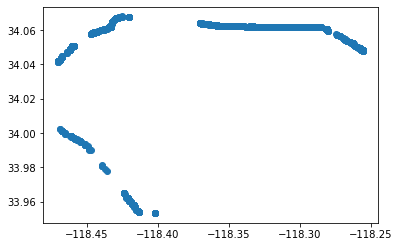

In [13]:
shade.plot()

In [14]:
shade.head()

trees_id cd          common            botanical      dbh  longitude  \
2261   425276  6    CAMPHOR TREE  Cinnamomum camphora   0 - 3"   -118.458   
2270   433530  6  EVERGREEN PEAR      Pyrus kawakamii  6 - 12"   -118.449   
2271   438940  6    LONDON PLANE  Platanus acerifolia   0 - 3"   -118.424   
2272   438941  6    LONDON PLANE  Platanus acerifolia   0 - 3"   -118.424   
2273   438943  6    LONDON PLANE  Platanus acerifolia   0 - 3"   -118.424   

      latitude                     geometry  
2261   33.9966  POINT (-118.45800 33.99660)  
2270   33.9923  POINT (-118.44900 33.99230)  
2271   33.9650  POINT (-118.42400 33.96500)  
2272   33.9650  POINT (-118.42400 33.96500)  
2273   33.9650  POINT (-118.42400 33.96500)

# Stops

In [15]:
url = "https://api.metro.net/agencies/lametro/routes/20/stops/"
stops = pd.read_json(url)

In [16]:
stops = pd.DataFrame(stops['items'].tolist())

In [17]:
stops = stops.sort_values(by='display_name')

In [18]:
stops.head(5)

id        display_name  latitude  longitude
14    03179       4th / Arizona  34.01792 -118.49701
164   00038      5th / Colorado  34.01388 -118.49020
80    03033      5th / Colorado  34.01474 -118.49117
161   03120  5th / Santa Monica  34.01755 -118.49449
68   104710          7th / Hill  34.04594 -118.25425

<div class="alert alert-danger">
We have a problem here. You have stops with the same name because they are on opposite sides of the street. This causes problems down the line when you group by stop, which pairs them up.
    
Let's create a unique ID column that combines the name and id to allow us to group correctly.
</div>

In [19]:
stops['unique_name'] = stops['display_name']+" ("+stops['id']+")"

In [20]:
stops.head()

id        display_name  latitude  longitude  \
14    03179       4th / Arizona  34.01792 -118.49701   
164   00038      5th / Colorado  34.01388 -118.49020   
80    03033      5th / Colorado  34.01474 -118.49117   
161   03120  5th / Santa Monica  34.01755 -118.49449   
68   104710          7th / Hill  34.04594 -118.25425   

                    unique_name  
14        4th / Arizona (03179)  
164      5th / Colorado (00038)  
80       5th / Colorado (03033)  
161  5th / Santa Monica (03120)  
68          7th / Hill (104710)

In [21]:
#stopsgdf = geopandas.GeoDataFrame(
  # stops, geometry=geopandas.points_from_xy(x=stops.longitude, y=stops.latitude))

stops = gpd.GeoDataFrame(stops, 
                        crs="EPSG:4326",
                        geometry=gpd.points_from_xy(x=stops.longitude, y=stops.latitude))

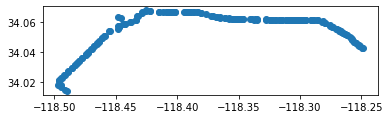

In [22]:
stops.plot()

In [23]:
# libraries

#import matplotlib.pyplot as plt

# for basemaps
import contextily as ctx

In [24]:
# reproject the data
stops = stops.to_crs('EPSG:3857')
shade = shade.to_crs('EPSG:3857')
trees = trees.to_crs('EPSG:3857')

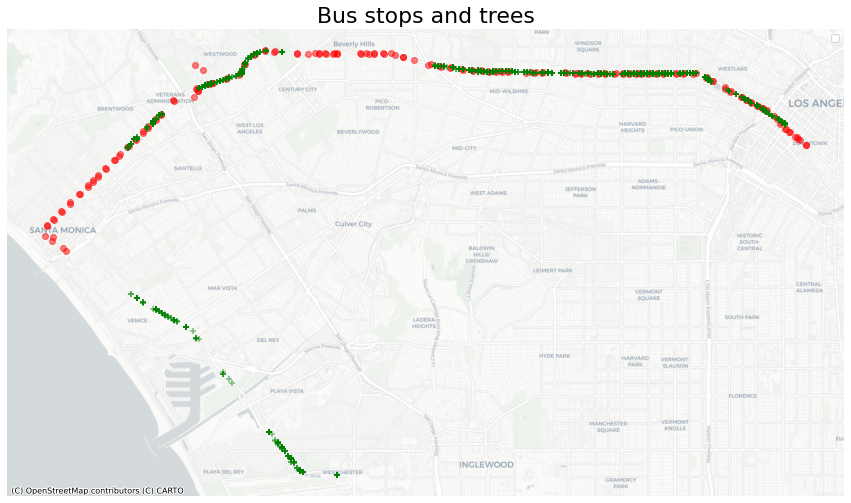

In [25]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

stops.plot(ax=ax,
         legend=True,
         alpha=0.5,
         color='red')

shade.plot(ax=ax, 
             color='green',
             marker = '+',
             alpha=0.5, 
             legend=True)

ax.axis('off')
ax.legend()
ax.set_title('Bus stops and trees',fontsize=22)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

# Buffer

In [26]:
# make a copy of stops first
stop_buffer = stops

In [27]:
# assign its geometry column to be the buffer
stop_buffer['geometry'] = stops.buffer(100)

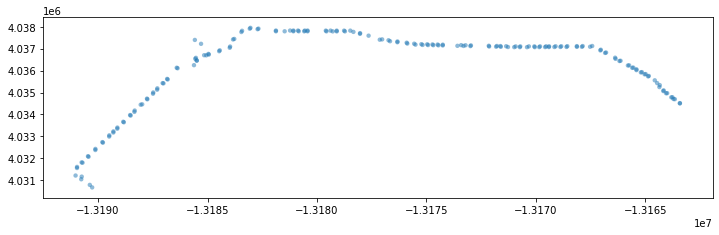

In [28]:
stop_buffer.plot(figsize=(12,12),alpha=0.5)

In [29]:
stop_buffer.shape

(183, 6)

In [30]:
stops.shape

(183, 6)

In [31]:
shade.shape

(1793, 8)

In [32]:
trees.shape

(2123, 8)

In [33]:
stop_buffer.head()

id        display_name  latitude  longitude  \
14    03179       4th / Arizona  34.01792 -118.49701   
164   00038      5th / Colorado  34.01388 -118.49020   
80    03033      5th / Colorado  34.01474 -118.49117   
161   03120  5th / Santa Monica  34.01755 -118.49449   
68   104710          7th / Hill  34.04594 -118.25425   

                    unique_name  \
14        4th / Arizona (03179)   
164      5th / Colorado (00038)   
80       5th / Colorado (03033)   
161  5th / Santa Monica (03120)   
68          7th / Hill (104710)   

                                              geometry  
14   POLYGON ((-13190926.814 4031208.498, -13190927...  
164  POLYGON ((-13190168.728 4030665.910, -13190169...  
80   POLYGON ((-13190276.697 4030781.406, -13190277...  
161  POLYGON ((-13190646.289 4031158.806, -13190646...  
68   POLYGON ((-13163902.894 4034972.315, -13163903...

# Spatial Join

In [34]:
# join trees to buffers
njoin = gpd.sjoin(shade, stop_buffer, how='right') 
pjoin = gpd.sjoin(trees, stop_buffer, how='right') 
#we want each bus stop buffer to be a row, so take data from right column to newgdf column

In [35]:
njoin.shape

(1821, 14)

In [36]:
njoin.head(4)

index_left trees_id cd             common                  botanical  \
5      2784.0     7588  5            RED GUM   EUCALYPTUS CAMALDULENSIS   
5      2804.0    25928  5         CARROTWOOD  Cupaniopsis anacardioides   
5      2975.0   104196  5  AMERICAN SWEETGUM    Liquidambar styraciflua   
5      2976.0   104226  5  AMERICAN SWEETGUM    Liquidambar styraciflua   

     dbh  longitude_x  latitude_x     id         display_name  latitude_y  \
5  36-42     -118.425     34.0680  08392  Wilshire / Comstock    34.06785   
5   3-12     -118.425     34.0679  08392  Wilshire / Comstock    34.06785   
5   3-12     -118.425     34.0679  08392  Wilshire / Comstock    34.06785   
5   3-12     -118.425     34.0679  08392  Wilshire / Comstock    34.06785   

   longitude_y                  unique_name  \
5   -118.42553  Wilshire / Comstock (08392)   
5   -118.42553  Wilshire / Comstock (08392)   
5   -118.42553  Wilshire / Comstock (08392)   
5   -118.42553  Wilshire / Comstock (08392)   

                                            geometry  
5  POLYGON ((-13182969.685 4037916.266, -13182970...  
5  POLYGON ((-13182969.685 4037916.266, -13182970...  
5  POLYGON ((-13182969.685 4037916.266, -13182970...  
5  POLYGON ((-13182969.685 4037916.266, -13182970...

## Trees, Shade Trees, and DBH

In [37]:
#i wanted to compare shade trees to all trees on this route, post-buffer
pdf = pjoin #palms
xdf = njoin #no palms

In [38]:
#palms cleanup
#this was the pain in the butt thing where I had to use regex to separate the dbh column into dbh1 and dbh2
arr = pdf['dbh'].str.split(r'[-|>|+]', expand = True)

arr = arr.replace(r'^\s*$', '36',regex=True)

pdf[['dbh1', 'dbh2']] = arr

pdf.head(2)

index_left trees_id cd               common              botanical    dbh  \
10      2780.0     5267  5  CALIFORNIA FAN PALM  Washingtonia filifera  24-36   
10      2791.0    15622  5         DEODAR CEDAR         Cedrus deodara  24-36   

    longitude_x  latitude_x     id       display_name  latitude_y  \
10     -118.432     34.0642  16773  Wilshire / Warner     34.0642   
10     -118.432     34.0642  16773  Wilshire / Warner     34.0642   

    longitude_y                unique_name  \
10   -118.43239  Wilshire / Warner (16773)   
10   -118.43239  Wilshire / Warner (16773)   

                                             geometry dbh1 dbh2  
10  POLYGON ((-13183733.348 4037425.765, -13183733...   24   36  
10  POLYGON ((-13183733.348 4037425.765, -13183733...   24   36

In [39]:
#this is where I remove the inches symbol from the data. ie. 36" becomes 36
pdf['dbh2'] = pdf['dbh2'].str.replace(r'\D', '')

In [40]:
pdf.shape

(2101, 16)

In [41]:
#now repeat for shade trees
arr = xdf['dbh'].str.split(r'[-|>|+]', expand = True)

arr = arr.replace(r'^\s*$', '36',regex=True)

xdf[['dbh1', 'dbh2']] = arr

xdf.head(2)

index_left trees_id cd      common                  botanical    dbh  \
5      2784.0     7588  5     RED GUM   EUCALYPTUS CAMALDULENSIS  36-42   
5      2804.0    25928  5  CARROTWOOD  Cupaniopsis anacardioides   3-12   

   longitude_x  latitude_x     id         display_name  latitude_y  \
5     -118.425     34.0680  08392  Wilshire / Comstock    34.06785   
5     -118.425     34.0679  08392  Wilshire / Comstock    34.06785   

   longitude_y                  unique_name  \
5   -118.42553  Wilshire / Comstock (08392)   
5   -118.42553  Wilshire / Comstock (08392)   

                                            geometry dbh1 dbh2  
5  POLYGON ((-13182969.685 4037916.266, -13182970...   36   42  
5  POLYGON ((-13182969.685 4037916.266, -13182970...    3   12

In [42]:
#again for shade trees
xdf['dbh2'] = xdf['dbh2'].str.replace(r'\D', '')

In [43]:
tree_type_counts = xdf.common.value_counts()
tree_type_counts = tree_type_counts.reset_index()
tree_type_counts.columns = ['common_name','count']
topten = tree_type_counts[tree_type_counts["count"] > 12]
topten

common_name  count
0       INDIAN LAUREL FIG    787
1               JACARANDA    235
2       SOUTHERN MAGNOLIA    194
3            CAMPHOR TREE    112
4            CRAPE MYRTLE     94
5            LONDON PLANE     78
6        PURPLE-LEAF PLUM     55
7  THORNLESS HONEY LOCUST     36
8         SILK-FLOSS TREE     25
9  QUEENSLAND PITTOSPORUM     19

In [44]:
palm_type_counts = pdf.common.value_counts()
palm_type_counts = palm_type_counts.reset_index()
palm_type_counts.columns = ['common_name','count']
palmstop = palm_type_counts[palm_type_counts["count"] > 35]
palmstop

common_name  count
0       INDIAN LAUREL FIG    787
1               JACARANDA    235
2        MEXICAN FAN PALM    212
3       SOUTHERN MAGNOLIA    194
4            CAMPHOR TREE    112
5            CRAPE MYRTLE     94
6            LONDON PLANE     78
7        PURPLE-LEAF PLUM     55
8  THORNLESS HONEY LOCUST     36
9               DATE PALM     36

In [45]:
fig = px.bar(topten,
       x='common_name',
       y='count',
              color='common_name',
       title='Most Popular Shade Trees',
       labels={'common_name':'Species', 'count':'Counts'}
      )

fig.update(layout_showlegend=False)

In [46]:
px.bar(palmstop,
       x='common_name',
       y='count',
       color='common_name',
       title='Most Popular Shade Trees',
       labels={'common_name':'Species', 'count':'Counts'}
      )

### please ignore this section 

In [47]:
#indian laurel fig is the smallest of the top 3 trees. 
#so knowing max dbh is 28 and max branch limb spread is 60 feet, 
#that's a respectable amount of shade for even a 10 ft dbh tree

In [48]:
xdf =xdf.sort_values(by='dbh2',ascending=False)
diameter_counts = xdf.dbh2.value_counts()
diameter_counts = diameter_counts.reset_index()
diameter_counts.columns = ['diameter','count']
diameter_counts=diameter_counts.sort_values(by='diameter',ascending=True)
diameter_counts
#I have no idea why the diameter values won't be in order. is it an issue of what type it is?

diameter  count
0       12    553
1       18    410
3       24    192
2        3    385
6       30     24
5       36     33
7       42      4
4        6    140

In [49]:
dbh = diameter_counts.astype('int64').sort_values(by='diameter',ascending=True).reset_index()

In [50]:
pig = px.bar(dbh,
       x='diameter',
       y='count',
             color='diameter',
       title='Shade Trees by Age & Cover',
       labels={'diameter':'DBH', 'count':'Counts'}
      )

pig.show()

## Trees per Stop

In [51]:
# new dataframe for count per stop
trees_by_stop = njoin.groupby(['id']).size().reset_index(name='treecount').sort_values(by='treecount')

In [52]:
trees_by_stop.sample(5)

id  treecount
145  16728         61
112  16675          1
81   08457          1
88   08470          1
83   08462         19

In [53]:
# join the count back to the buffers
stop_buffer=stop_buffer.merge(trees_by_stop,on='id')
stop_buffer.head(5)

id        display_name  latitude  longitude  \
0   03179       4th / Arizona  34.01792 -118.49701   
1   00038      5th / Colorado  34.01388 -118.49020   
2   03033      5th / Colorado  34.01474 -118.49117   
3   03120  5th / Santa Monica  34.01755 -118.49449   
4  104710          7th / Hill  34.04594 -118.25425   

                  unique_name  \
0       4th / Arizona (03179)   
1      5th / Colorado (00038)   
2      5th / Colorado (03033)   
3  5th / Santa Monica (03120)   
4         7th / Hill (104710)   

                                            geometry  treecount  
0  POLYGON ((-13190926.814 4031208.498, -13190927...          1  
1  POLYGON ((-13190168.728 4030665.910, -13190169...          1  
2  POLYGON ((-13190276.697 4030781.406, -13190277...          1  
3  POLYGON ((-13190646.289 4031158.806, -13190646...          1  
4  POLYGON ((-13163902.894 4034972.315, -13163903...          1

In [54]:
#stopbuff =trees_by_stop.merge(stop_buffer, on = 'id')

In [55]:
# sort it
#stopbuff = stopbuff.sort_values(by='treecount',ascending=False)
stop_buffer=stop_buffer.sort_values(by='treecount', ascending=False)

In [56]:
stop_buffer.head()

id         display_name  latitude  longitude  \
93  16728  Wilshire / Kingsley  34.06186 -118.30270   
92  08428  Wilshire / Kingsley  34.06161 -118.30278   
69  16713  Wilshire / Coronado  34.06070 -118.28149   
70  08414  Wilshire / Coronado  34.06047 -118.28164   
74  02449    Wilshire / Curson  34.06233 -118.35461   

                    unique_name  \
93  Wilshire / Kingsley (16728)   
92  Wilshire / Kingsley (08428)   
69  Wilshire / Coronado (16713)   
70  Wilshire / Coronado (08414)   
74    Wilshire / Curson (02449)   

                                             geometry  treecount  
93  POLYGON ((-13169296.323 4037111.340, -13169296...         61  
92  POLYGON ((-13169305.229 4037077.734, -13169305...         61  
69  POLYGON ((-13166935.226 4036955.455, -13166935...         54  
70  POLYGON ((-13166951.935 4036924.563, -13166952...         54  
74  POLYGON ((-13175074.907 4037174.483, -13175075...         54

In [57]:
stop_buffer.shape

(182, 7)

In [58]:
stop_buffer.sum()

id              1672808428167130841402449167000844916750167440...
display_name    Wilshire / KingsleyWilshire / KingsleyWilshire...
latitude                                                  6197.95
longitude                                                -21543.7
unique_name     Wilshire / Kingsley (16728)Wilshire / Kingsley...
treecount                                                    1820
dtype: object

In [59]:
# make a stacked bar chart
fig = px.bar(stop_buffer[stop_buffer['treecount']>25],
           y='unique_name',
           x='treecount',
           height=800,
           orientation='h'
      )

fig.update_layout(yaxis_type='category') # need this to force the id to be categorical
fig.show()

As an idea, you could create a function here where you can specify the number of trees to show.

## Function

In [60]:
# import that interact library
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [61]:
shadestops = stop_buffer

In [62]:
alltrees = trees_by_stop.treecount.tolist()

In [63]:
print("Original List : ",alltrees)
my_set = set(alltrees)
my_new_list = list(my_set)
print("List of unique numbers : ",my_new_list)

Original List :  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 21, 21, 21, 21, 23, 23, 24, 24, 26, 26, 26, 27, 27, 27, 28, 28, 29, 29, 29, 30, 36, 39, 39, 43, 43, 44, 54, 54, 54, 61, 61]
List of unique numbers :  [1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 24, 26, 27, 28, 29, 30, 36, 39, 43, 44, 54, 61]


In [64]:
strees = my_new_list

id         display_name  latitude  longitude  \
173  08470  Wilshire / Whittier  34.06697 -118.41480   
124  08442      Wilshire / Peck  34.06695 -118.40317   
180  16780      Wilshire / Yale  34.03850 -118.47463   
175  08457  Wilshire / Willaman  34.06610 -118.38030   
174  16759  Wilshire / Willaman  34.06635 -118.38027   

                     unique_name  \
173  Wilshire / Whittier (08470)   
124      Wilshire / Peck (08442)   
180      Wilshire / Yale (16780)   
175  Wilshire / Willaman (08457)   
174  Wilshire / Willaman (16759)   

                                              geometry  treecount  
173  POLYGON ((-13181775.227 4037798.010, -13181775...          1  
124  POLYGON ((-13180480.593 4037795.322, -13180481...          1  
180  POLYGON ((-13188435.472 4033972.808, -13188435...          1  
175  POLYGON ((-13177934.716 4037681.098, -13177935...          1  
174  POLYGON ((-13177931.376 4037714.693, -13177931...          1

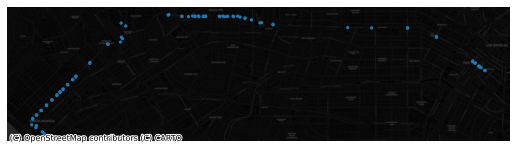

In [65]:
# table
display(shadestops[shadestops.treecount == 1].head()) 

# map
ax = shadestops[shadestops.treecount == 1].plot(figsize=(9,9), markersize=1)

# axis
ax.axis('off')

# basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)

In [66]:
def place_by(treecount = 1): 
    # table
    display(shadestops[shadestops.treecount == treecount].head()) 
    
    # map
    ax = shadestops[shadestops.treecount == treecount].plot(figsize=(9,9), markersize=2)
    
    # axis
    ax.axis('off')
    
    # basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)

id         display_name  latitude  longitude  \
173  08470  Wilshire / Whittier  34.06697 -118.41480   
124  08442      Wilshire / Peck  34.06695 -118.40317   
180  16780      Wilshire / Yale  34.03850 -118.47463   
175  08457  Wilshire / Willaman  34.06610 -118.38030   
174  16759  Wilshire / Willaman  34.06635 -118.38027   

                     unique_name  \
173  Wilshire / Whittier (08470)   
124      Wilshire / Peck (08442)   
180      Wilshire / Yale (16780)   
175  Wilshire / Willaman (08457)   
174  Wilshire / Willaman (16759)   

                                              geometry  treecount  
173  POLYGON ((-13181775.227 4037798.010, -13181775...          1  
124  POLYGON ((-13180480.593 4037795.322, -13180481...          1  
180  POLYGON ((-13188435.472 4033972.808, -13188435...          1  
175  POLYGON ((-13177934.716 4037681.098, -13177935...          1  
174  POLYGON ((-13177931.376 4037714.693, -13177931...          1

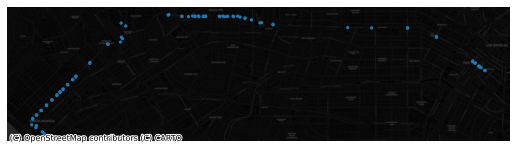

In [67]:
place_by(treecount = 1) #error but don't know why

In [68]:
@interact
# create a function
def stops_by(treecount =strees):  
    
    display(shadestops[shadestops.treecount == treecount].head()) 
    
    # map
    ax = shadestops[shadestops.treecount == treecount].plot(figsize=(34,34), markersize=2)
    
    # axis
    ax.axis('off')
    
    # basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)

interactive(children=(Dropdown(description='treecount', options=(1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 1…

# Benches

In [69]:
benches=gpd.read_file('../gdata/Bus_Stop_Benches.shp')

In [70]:
benches.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Spatial join: Benches per stop

In [71]:
#Reproject the data
benches = benches.to_crs('EPSG:3857')

In [72]:
#Spatial join of benches and stops
bjoin=gpd.sjoin(benches, stop_buffer, how='right')

In [73]:
bjoin.shape

(292, 21)

In [74]:
bjoin.head()

index_left  OBJECTID    FID2   NUMBER  LATITUDE  LONGITUDE  \
71         8.0       9.0  1542.0  LA-1543  34.06147 -118.31958   
71         9.0      10.0  1548.0  LA-1549  34.06147 -118.31958   
71        10.0      11.0  1551.0  LA-1552  34.06147 -118.31958   
71        64.0      65.0  1538.0  LA-1539  34.06147 -118.31958   
71        65.0      66.0  1558.0  LA-1559  34.06147 -118.31958   

                             SITEATS     CITY_SITE FACING MEDIA_TYPE  ...  \
71    EB  Wilshire  FS  Dunsmuir -SE  L.A. Central   West  Bus Bench  ...   
71     EB  Wilshire  NS  La Brea -SW  L.A. Central   East  Bus Bench  ...   
71    WB  Wilshire  FS  Lorraine -NW  L.A. Central  North  Bus Bench  ...   
71  EB  Wilshire  FS  Cloverdale -SE  L.A. Central   West  Bus Bench  ...   
71    WB  Wilshire  FS  Ridgeley -NW  L.A. Central  North  Bus Bench  ...   

     AREA              ADVERTISER  \
71  CD-04                MOM L.A.   
71  CD-04  Diamond Foam & Fabrics   
71  CD-04                MOM L.A.   
71  CD-04                MOM L.A.   
71  CD-04                MOM L.A.   

                                              TOOLTIP     id  \
71  Location: EB  Wilshire  FS  Dunsmuir -SE\nNumb...  00928   
71  Location: EB  Wilshire  NS  La Brea -SW\nNumbe...  00928   
71  Location: WB  Wilshire  FS  Lorraine -NW\nNumb...  00928   
71  Location: EB  Wilshire  FS  Cloverdale -SE\nNu...  00928   
71  Location: WB  Wilshire  FS  Ridgeley -NW\nNumb...  00928   

           display_name  latitude  longitude                  unique_name  \
71  Wilshire / Crenshaw  34.06162 -118.31957  Wilshire / Crenshaw (00928)   
71  Wilshire / Crenshaw  34.06162 -118.31957  Wilshire / Crenshaw (00928)   
71  Wilshire / Crenshaw  34.06162 -118.31957  Wilshire / Crenshaw (00928)   
71  Wilshire / Crenshaw  34.06162 -118.31957  Wilshire / Crenshaw (00928)   
71  Wilshire / Crenshaw  34.06162 -118.31957  Wilshire / Crenshaw (00928)   

                                             geometry treecount  
71  POLYGON ((-13171174.283 4037079.077, -13171174...        10  
71  POLYGON ((-13171174.283 4037079.077, -13171174...        10  
71  POLYGON ((-13171174.283 4037079.077, -13171174...        10  
71  POLYGON ((-13171174.283 4037079.077, -13171174...        10  
71  POLYGON ((-13171174.283 4037079.077, -13171174...        10  

[5 rows x 21 columns]

In [75]:
# new dataframe for number of benches per stop
benches_by_stop = bjoin.groupby(['id']).size().reset_index(name='benchescount').sort_values(by='benchescount')

In [76]:
benches_by_stop.sample(5)

id  benchescount
146  16732             1
106  16663             1
2    01220             1
108  16665             1
70   08442             1

In [77]:
#Now lets join the benches back to stopsbuffer
stop_buffer=stop_buffer.merge(benches_by_stop,on='id')

In [78]:
stop_buffer.head()

id         display_name  latitude  longitude  \
0  16728  Wilshire / Kingsley  34.06186 -118.30270   
1  08428  Wilshire / Kingsley  34.06161 -118.30278   
2  16713  Wilshire / Coronado  34.06070 -118.28149   
3  08414  Wilshire / Coronado  34.06047 -118.28164   
4  02449    Wilshire / Curson  34.06233 -118.35461   

                   unique_name  \
0  Wilshire / Kingsley (16728)   
1  Wilshire / Kingsley (08428)   
2  Wilshire / Coronado (16713)   
3  Wilshire / Coronado (08414)   
4    Wilshire / Curson (02449)   

                                            geometry  treecount  benchescount  
0  POLYGON ((-13169296.323 4037111.340, -13169296...         61             1  
1  POLYGON ((-13169305.229 4037077.734, -13169305...         61             1  
2  POLYGON ((-13166935.226 4036955.455, -13166935...         54             3  
3  POLYGON ((-13166951.935 4036924.563, -13166952...         54             3  
4  POLYGON ((-13175074.907 4037174.483, -13175075...         54             1

In [79]:
stop_buffer = stop_buffer.sort_values(by='benchescount',ascending=False)
stop_buffer

id                display_name  latitude  longitude  \
63    00928         Wilshire / Crenshaw  34.06162 -118.31957   
35   104706            Wilshire / Bundy  34.04385 -118.46756   
33   104702            Wilshire / Bundy  34.04408 -118.46771   
27    08467          Wilshire / Western  34.06184 -118.30874   
49    16692  Do Not Announce This Stop!  34.06309 -118.36114   
..      ...                         ...       ...        ...   
73    16751    Wilshire / Saint Andrews  34.06157 -118.31176   
72    16725         Wilshire / Highland  34.06226 -118.33879   
70    08418         Wilshire / Dunsmuir  34.06220 -118.34812   
68    08400         Wilshire / Lorraine  34.06189 -118.32032   
181   08472             Wilshire / Yale  34.03832 -118.47442   

                            unique_name  \
63          Wilshire / Crenshaw (00928)   
35            Wilshire / Bundy (104706)   
33            Wilshire / Bundy (104702)   
27           Wilshire / Western (08467)   
49   Do Not Announce This Stop! (16692)   
..                                  ...   
73     Wilshire / Saint Andrews (16751)   
72          Wilshire / Highland (16725)   
70          Wilshire / Dunsmuir (08418)   
68          Wilshire / Lorraine (08400)   
181             Wilshire / Yale (08472)   

                                              geometry  treecount  \
63   POLYGON ((-13171174.283 4037079.077, -13171174...         10   
35   POLYGON ((-13187648.444 4034691.531, -13187648...         18   
33   POLYGON ((-13187665.153 4034722.417, -13187665...         18   
27   POLYGON ((-13169968.693 4037108.639, -13169969...         21   
49   POLYGON ((-13175801.835 4037276.607, -13175802...         14   
..                                                 ...        ...   
73   POLYGON ((-13170304.878 4037072.372, -13170305...          8   
72   POLYGON ((-13173313.833 4037165.076, -13173314...          8   
70   POLYGON ((-13174352.444 4037157.014, -13174352...          8   
68   POLYGON ((-13171257.773 4037115.358, -13171258...          9   
181  POLYGON ((-13188412.095 4033948.627, -13188412...          1   

     benchescount  
63             23  
35              7  
33              7  
27              4  
49              4  
..            ...  
73              1  
72              1  
70              1  
68              1  
181             1  

[182 rows x 8 columns]

In [80]:
#Lets visualize benches per stop buffer
fig = px.bar(stop_buffer[stop_buffer['benchescount']>5],
           y='unique_name',
           x='benchescount',
           height=800,
           orientation='h'
      )

fig.update_layout(yaxis_type='category') # need this to force the id to be categorical
fig.show()

# Income

In [81]:
income=gpd.read_file('../gdata/acs2018_5yr_B19013_14000US06037204600.geojson')
                            #acs2018_5yr_B19013_14000US06037204600.geojson


In [82]:
income.tail()

geoid                                   name  B19013001  \
2342  14000US06037980031  Census Tract 9800.31, Los Angeles, CA    64500.0   
2343  14000US06037980033  Census Tract 9800.33, Los Angeles, CA        NaN   
2344  14000US06037990100     Census Tract 9901, Los Angeles, CA        NaN   
2345  14000US06037990200     Census Tract 9902, Los Angeles, CA        NaN   
2346  14000US06037990300     Census Tract 9903, Los Angeles, CA        NaN   

      B19013001, Error                                           geometry  
2342           44253.0  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...  
2343               NaN  MULTIPOLYGON (((-118.24897 33.75590, -118.2470...  
2344               NaN  MULTIPOLYGON (((-118.95114 33.99643, -118.9505...  
2345               NaN  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...  
2346               NaN  MULTIPOLYGON (((-118.47656 33.75038, -118.4661...

In [83]:
income.head()

geoid                                   name  B19013001  \
0        05000US06037                 Los Angeles County, CA    64251.0   
1  14000US06037101110  Census Tract 1011.10, Los Angeles, CA    53077.0   
2  14000US06037101122  Census Tract 1011.22, Los Angeles, CA    88953.0   
3  14000US06037101210  Census Tract 1012.10, Los Angeles, CA    32119.0   
4  14000US06037101220  Census Tract 1012.20, Los Angeles, CA    41728.0   

   B19013001, Error                                           geometry  
0             247.0  MULTIPOLYGON (((-118.70339 34.16859, -118.7033...  
1           14466.0  MULTIPOLYGON (((-118.30229 34.25870, -118.3009...  
2           10913.0  MULTIPOLYGON (((-118.30334 34.27371, -118.3033...  
3           11957.0  MULTIPOLYGON (((-118.29945 34.25598, -118.2979...  
4            3976.0  MULTIPOLYGON (((-118.28593 34.25227, -118.2859...

In [84]:
#notice for some reason we dont have the sum of LA County data that we talked abt in class. 
#so no need to remove... 

In [85]:
income=income[['geoid','name','geometry','B19013001',]]

In [86]:
income.columns=['geoid','censustracts','geometry','hhincome']

In [87]:
income.tail()

geoid                           censustracts  \
2342  14000US06037980031  Census Tract 9800.31, Los Angeles, CA   
2343  14000US06037980033  Census Tract 9800.33, Los Angeles, CA   
2344  14000US06037990100     Census Tract 9901, Los Angeles, CA   
2345  14000US06037990200     Census Tract 9902, Los Angeles, CA   
2346  14000US06037990300     Census Tract 9903, Los Angeles, CA   

                                               geometry  hhincome  
2342  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...   64500.0  
2343  MULTIPOLYGON (((-118.24897 33.75590, -118.2470...       NaN  
2344  MULTIPOLYGON (((-118.95114 33.99643, -118.9505...       NaN  
2345  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...       NaN  
2346  MULTIPOLYGON (((-118.47656 33.75038, -118.4661...       NaN

In [88]:
income.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [89]:
income = income.to_crs('EPSG:3857')

In [90]:
income["hhincome"].describe()

count      2309.000000
mean      69675.671286
std       33863.952081
min        8264.000000
25%       45000.000000
50%       62917.000000
75%       85950.000000
max      250001.000000
Name: hhincome, dtype: float64

In [91]:
income=income.query("hhincome !='NaN'", engine='python')
income.head()

geoid                           censustracts  \
0        05000US06037                 Los Angeles County, CA   
1  14000US06037101110  Census Tract 1011.10, Los Angeles, CA   
2  14000US06037101122  Census Tract 1011.22, Los Angeles, CA   
3  14000US06037101210  Census Tract 1012.10, Los Angeles, CA   
4  14000US06037101220  Census Tract 1012.20, Los Angeles, CA   

                                            geometry  hhincome  
0  MULTIPOLYGON (((-13214001.153 4051462.206, -13...   64251.0  
1  MULTIPOLYGON (((-13169350.794 4063591.834, -13...   53077.0  
2  MULTIPOLYGON (((-13169467.902 4065613.937, -13...   88953.0  
3  MULTIPOLYGON (((-13169034.646 4063225.625, -13...   32119.0  
4  MULTIPOLYGON (((-13167528.939 4062726.771, -13...   41728.0

In [92]:
income.shape

(2309, 4)

In [93]:
#Lets see if we can do spatial join with income.

In [94]:
ijoin=gpd.sjoin(income, stop_buffer, how='right')

In [95]:
ijoin.shape

(565, 12)

In [96]:
ijoin.sample(5)

index_left               geoid                           censustracts  \
61          635  14000US06037215102  Census Tract 2151.02, Los Angeles, CA   
140         541  14000US06037207301  Census Tract 2073.01, Los Angeles, CA   
99         2113  14000US06037700700     Census Tract 7007, Los Angeles, CA   
122           0        05000US06037                 Los Angeles County, CA   
39          854  14000US06037265510  Census Tract 2655.10, Los Angeles, CA   

     hhincome     id           display_name  latitude  longitude  \
61    65000.0  16711  Wilshire / Cloverdale  34.06242 -118.34633   
140   52581.0  15761           7th / Spring  34.04452 -118.25254   
99   209890.0  08470    Wilshire / Whittier  34.06697 -118.41480   
122   64251.0  08440        Wilshire / Palm  34.06694 -118.39149   
39    52917.0  16693     Wilshire / Glendon  34.05928 -118.44251   

                       unique_name  \
61   Wilshire / Cloverdale (16711)   
140           7th / Spring (15761)   
99     Wilshire / Whittier (08470)   
122        Wilshire / Palm (08440)   
39      Wilshire / Glendon (16693)   

                                              geometry  treecount  \
61   POLYGON ((-13174153.193 4037186.590, -13174153...         12   
140  POLYGON ((-13163712.527 4034781.529, -13163713...          1   
99   POLYGON ((-13181775.227 4037798.010, -13181775...          1   
122  POLYGON ((-13179180.381 4037793.978, -13179180...          1   
39   POLYGON ((-13184859.890 4036764.662, -13184860...         16   

     benchescount  
61              1  
140             1  
99              1  
122             1  
39              2

In [97]:
ijoin["hhincome"].describe()

count       565.000000
mean      71421.529204
std       27902.599562
min       10294.000000
25%       64083.000000
50%       64251.000000
75%       87344.000000
max      209890.000000
Name: hhincome, dtype: float64

In [98]:
import matplotlib.pyplot as plt 

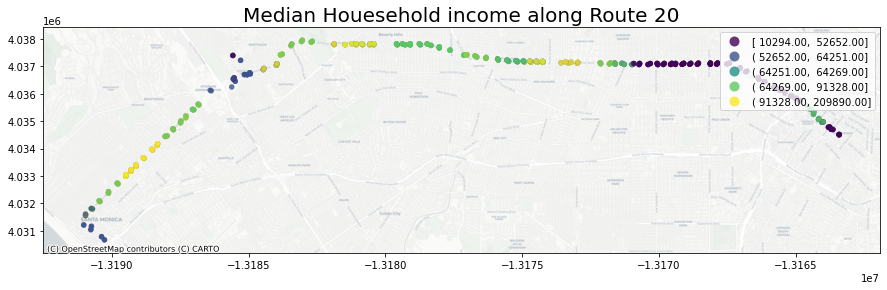

In [99]:
ax = ijoin.plot(figsize=(15,15),
                        column='hhincome',
                        legend=True,
                        alpha=0.8,
                        scheme='quantiles')
ax.set_title('Median Houesehold income along Route 20',fontsize=20)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

# Summarized #of trees and benches

In [100]:
import matplotlib.pyplot as plt 

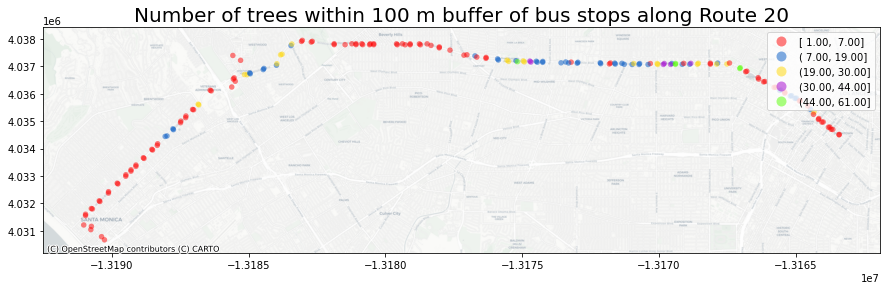

In [101]:
ax = stop_buffer.plot(figsize=(15,15),
                        column='treecount',
                        legend=True,
                        alpha=0.5,
                        cmap='prism',
                        scheme='naturalbreaks')
ax.set_title('Number of trees within 100 m buffer of bus stops along Route 20',fontsize=20)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

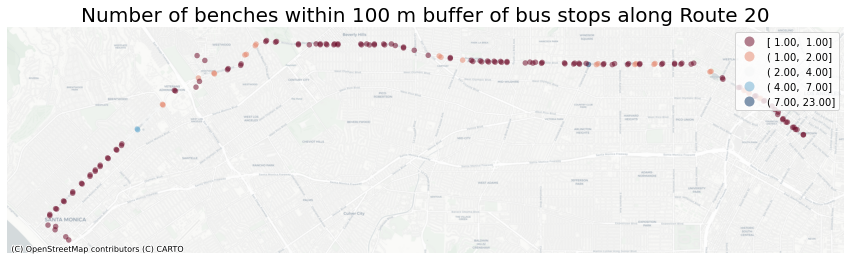

In [102]:
ax = stop_buffer.plot(figsize=(15,15),
                        column='benchescount',
                        legend=True,
                        alpha=0.5,
                        cmap='RdBu',
                        scheme='naturalbreaks')
ax.set_title('Number of benches within 100 m buffer of bus stops along Route 20',fontsize=20)
ax.axis('off')
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [103]:
stop_buffer.head()

id                display_name  latitude  longitude  \
63   00928         Wilshire / Crenshaw  34.06162 -118.31957   
35  104706            Wilshire / Bundy  34.04385 -118.46756   
33  104702            Wilshire / Bundy  34.04408 -118.46771   
27   08467          Wilshire / Western  34.06184 -118.30874   
49   16692  Do Not Announce This Stop!  34.06309 -118.36114   

                           unique_name  \
63         Wilshire / Crenshaw (00928)   
35           Wilshire / Bundy (104706)   
33           Wilshire / Bundy (104702)   
27          Wilshire / Western (08467)   
49  Do Not Announce This Stop! (16692)   

                                             geometry  treecount  benchescount  
63  POLYGON ((-13171174.283 4037079.077, -13171174...         10            23  
35  POLYGON ((-13187648.444 4034691.531, -13187648...         18             7  
33  POLYGON ((-13187665.153 4034722.417, -13187665...         18             7  
27  POLYGON ((-13169968.693 4037108.639, -13169969...         21             4  
49  POLYGON ((-13175801.835 4037276.607, -13175802...         14             4

# Stops with most and least number of trees and benches

In [104]:
df1 = pd.DataFrame(stop_buffer)

In [105]:
dftop5t=df1.nlargest(5,'treecount')

In [106]:
fig=px.bar(dftop5t,
       x='unique_name',
       y='treecount',
       title='Top 5 bus stops with most number of trees',
       labels={'unique_name':'Bus Stops','treecount':'Number of trees'}
        
      )
fig.update_traces(marker_line_width=0)

In [107]:
dftop5b=df1.nlargest(5,'benchescount')

In [108]:
figb=px.bar(dftop5b,
       x='unique_name',
       y='benchescount',
       title='Top 5 bus stops with most number of benches',
       labels={'unique_name':'Bus Stops','benchescount':'Number of benches'}
        
      )
figb.update_traces(marker_line_width=0)

In [109]:
dfs5t=df1.nsmallest(5,'treecount')

In [110]:
figst=px.bar(dfs5t,
       x='unique_name',
       y='treecount',
       title='Bus stops with least number of trees',
       labels={'unique_name':'Bus Stops','treecount':'Number of trees'}
        
      )
figst.update_traces(marker_line_width=0)

In [111]:
dfs5b=df1.nsmallest(5,'benchescount')

In [112]:
figst=px.bar(dfs5b,
       x='unique_name',
       y='benchescount',
       title='Bus stops with least number of trees',
       labels={'unique_name':'Bus Stops','benchescount':'Number of benches'}
        
      )
figst.update_traces(marker_line_width=0)

# Combined analysis

In [113]:
import numpy as np

In [114]:
# create a list of our conditions
conditions = [
    (stop_buffer['treecount'] > 25) & (stop_buffer['benchescount'] > 5),
    (stop_buffer['treecount'] > 25),
    (stop_buffer['benchescount'] > 5),
    (stop_buffer['treecount'] <=25) & (stop_buffer['benchescount']<=5)
    ]

# create a list of the values we want to assign for each condition
values = ['IdealShade+Bench', 'IdealShade', 'IdealBench', 'Notideal']

# create a new column and use np.select to assign values to it using our lists as arguments
stop_buffer['shadebenchindex'] = np.select(conditions, values)

conditions1 = [
    (stop_buffer['treecount'] > 25) & (stop_buffer['benchescount'] > 5),
    (stop_buffer['treecount'] > 25),
    (stop_buffer['benchescount'] > 5),
    (stop_buffer['treecount'] <=25) & (stop_buffer['benchescount']<=5)
    ]

# create a list of the values we want to assign for each condition
values1 = ['A - both', 'C - shade', 'B - bench', 'D - none']

stop_buffer['indexed'] = np.select(conditions1, values1)

# display updated DataFrame
stop_buffer.head()

id                display_name  latitude  longitude  \
63   00928         Wilshire / Crenshaw  34.06162 -118.31957   
35  104706            Wilshire / Bundy  34.04385 -118.46756   
33  104702            Wilshire / Bundy  34.04408 -118.46771   
27   08467          Wilshire / Western  34.06184 -118.30874   
49   16692  Do Not Announce This Stop!  34.06309 -118.36114   

                           unique_name  \
63         Wilshire / Crenshaw (00928)   
35           Wilshire / Bundy (104706)   
33           Wilshire / Bundy (104702)   
27          Wilshire / Western (08467)   
49  Do Not Announce This Stop! (16692)   

                                             geometry  treecount  \
63  POLYGON ((-13171174.283 4037079.077, -13171174...         10   
35  POLYGON ((-13187648.444 4034691.531, -13187648...         18   
33  POLYGON ((-13187665.153 4034722.417, -13187665...         18   
27  POLYGON ((-13169968.693 4037108.639, -13169969...         21   
49  POLYGON ((-13175801.835 4037276.607, -13175802...         14   

    benchescount shadebenchindex    indexed  
63            23      IdealBench  B - bench  
35             7      IdealBench  B - bench  
33             7      IdealBench  B - bench  
27             4        Notideal   D - none  
49             4        Notideal   D - none

In [115]:
stop_buffer.tail()

id              display_name  latitude  longitude  \
73   16751  Wilshire / Saint Andrews  34.06157 -118.31176   
72   16725       Wilshire / Highland  34.06226 -118.33879   
70   08418       Wilshire / Dunsmuir  34.06220 -118.34812   
68   08400       Wilshire / Lorraine  34.06189 -118.32032   
181  08472           Wilshire / Yale  34.03832 -118.47442   

                          unique_name  \
73   Wilshire / Saint Andrews (16751)   
72        Wilshire / Highland (16725)   
70        Wilshire / Dunsmuir (08418)   
68        Wilshire / Lorraine (08400)   
181           Wilshire / Yale (08472)   

                                              geometry  treecount  \
73   POLYGON ((-13170304.878 4037072.372, -13170305...          8   
72   POLYGON ((-13173313.833 4037165.076, -13173314...          8   
70   POLYGON ((-13174352.444 4037157.014, -13174352...          8   
68   POLYGON ((-13171257.773 4037115.358, -13171258...          9   
181  POLYGON ((-13188412.095 4033948.627, -13188412...          1   

     benchescount shadebenchindex   indexed  
73              1        Notideal  D - none  
72              1        Notideal  D - none  
70              1        Notideal  D - none  
68              1        Notideal  D - none  
181             1        Notideal  D - none

In [116]:
stop_buffer['indexed'].value_counts()

D - none     156
C - shade     23
B - bench      3
Name: indexed, dtype: int64

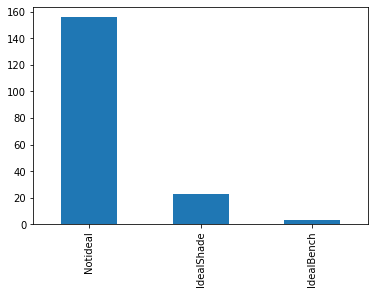

In [117]:
stop_buffer['shadebenchindex'].value_counts().plot(kind='bar')

In [118]:
#So none of these stops have ideal shade and bench, based on our definitions..?I dont know if that makes sense. 

In [119]:
#Remaining tasks 
#Does a stop have bus or bench or both (kind of done or have a first version)
#Function by number of trees or by distance
#Making spatial joined maps prettier

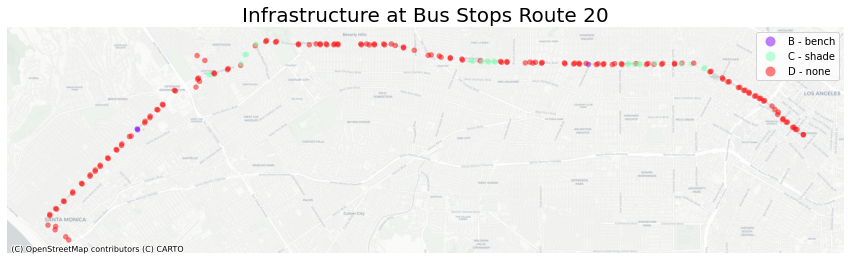

In [120]:
ax = stop_buffer.plot(figsize=(15,15),
                        column='indexed',
                        legend=True,
                        alpha=0.5,
                        cmap='rainbow')
ax.set_title('Infrastructure at Bus Stops Route 20',fontsize=20)
ax.axis('off')
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [121]:
latitude = stop_buffer.latitude.mean()
latitude

longitude = stop_buffer.longitude.mean()
longitude

-118.37209012527475

In [122]:
import folium

In [123]:
m = folium.Map(location=[latitude,longitude], tiles='Stamen Terrain', zoom_start=10)
m

In [124]:
for index, row in stop_buffer.iterrows():
    folium.Marker(
        [row.latitude,row.longitude], 
        popup=row.indexed, #what pops up when you click
        tooltip=row.unique_name #when you hover on the icon
).add_to(m)

In [125]:
stop_buffer['color'] = ''
stop_buffer.head()

id                display_name  latitude  longitude  \
63   00928         Wilshire / Crenshaw  34.06162 -118.31957   
35  104706            Wilshire / Bundy  34.04385 -118.46756   
33  104702            Wilshire / Bundy  34.04408 -118.46771   
27   08467          Wilshire / Western  34.06184 -118.30874   
49   16692  Do Not Announce This Stop!  34.06309 -118.36114   

                           unique_name  \
63         Wilshire / Crenshaw (00928)   
35           Wilshire / Bundy (104706)   
33           Wilshire / Bundy (104702)   
27          Wilshire / Western (08467)   
49  Do Not Announce This Stop! (16692)   

                                             geometry  treecount  \
63  POLYGON ((-13171174.283 4037079.077, -13171174...         10   
35  POLYGON ((-13187648.444 4034691.531, -13187648...         18   
33  POLYGON ((-13187665.153 4034722.417, -13187665...         18   
27  POLYGON ((-13169968.693 4037108.639, -13169969...         21   
49  POLYGON ((-13175801.835 4037276.607, -13175802...         14   

    benchescount shadebenchindex    indexed color  
63            23      IdealBench  B - bench        
35             7      IdealBench  B - bench        
33             7      IdealBench  B - bench        
27             4        Notideal   D - none        
49             4        Notideal   D - none

In [126]:
stop_buffer.loc[stop_buffer['indexed'] == 'B - bench']

id         display_name  latitude  longitude  \
63   00928  Wilshire / Crenshaw  34.06162 -118.31957   
35  104706     Wilshire / Bundy  34.04385 -118.46756   
33  104702     Wilshire / Bundy  34.04408 -118.46771   

                    unique_name  \
63  Wilshire / Crenshaw (00928)   
35    Wilshire / Bundy (104706)   
33    Wilshire / Bundy (104702)   

                                             geometry  treecount  \
63  POLYGON ((-13171174.283 4037079.077, -13171174...         10   
35  POLYGON ((-13187648.444 4034691.531, -13187648...         18   
33  POLYGON ((-13187665.153 4034722.417, -13187665...         18   

    benchescount shadebenchindex    indexed color  
63            23      IdealBench  B - bench        
35             7      IdealBench  B - bench        
33             7      IdealBench  B - bench

In [127]:
stop_buffer.loc[stop_buffer['indexed'] == 'A - both', 'color'] = 'purple'
stop_buffer.loc[stop_buffer['indexed'] == 'B - bench', 'color'] = 'blue'
stop_buffer.loc[stop_buffer['indexed'] == 'C - shade', 'color'] = 'green'
stop_buffer.loc[stop_buffer['indexed'] == 'D - none', 'color'] = 'darkred'

In [128]:
import folium

m = folium.Map(location=[latitude,longitude], tiles='Stamen Terrain', zoom_start=12)
m

#add the stations
for index, row in stop_buffer.iterrows():
    folium.Marker(
        [row.latitude,row.longitude], 
        popup=row.indexed, #what pops up when you click
        tooltip=row.unique_name, #when you hover on the icon
        icon=folium.Icon(color=row.color)
).add_to(m)

m